In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [127]:
df = pd.read_csv("./data/data.csv", delimiter=';', encoding='latin1')

In [128]:
def show_full_dataset(df):
    with pd.option_context('display.max_columns', None,
                       'display.max_colwidth', None,
                       'display.max_rows', 100):
        display(df)

### Diccionario de Variables

| Columna                   | Descripción                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| Group                     | Tipo de ED: 1 = Local (3er nivel), 2 = Regional (4to nivel)                 |
| Sex                       | Sexo del paciente: 1 = Mujer, 2 = Hombre                                    |
| Age                       | Edad del paciente (años)                                                    |
| Patients number per hour  | Número de pacientes que llegan por hora al ED                              |
| Arrival mode              | Modo de llegada: 1=Camina, 2=Ambulancia pública, 3=Vehículo privado, etc.  |
| Injury                    | Si llegó por lesión: 1 = No, 2 = Sí                                         |
| Chief_complain            | Queja principal del paciente                                                |
| Mental                    | Estado mental: 1=Alerta, 2=Respuesta verbal, 3=Dolor, 4=Inconsciente       |
| Pain                      | Tiene dolor: 1 = Sí, 0 = No                                                 |
| NRS_pain                  | Escala numérica del dolor (0-10)                                            |
| SBP                       | Presión arterial sistólica (mmHg)                                           |
| DBP                       | Presión arterial diastólica (mmHg)                                          |
| HR                        | Frecuencia cardíaca (latidos por minuto)                                   |
| RR                        | Frecuencia respiratoria (respiraciones por minuto)                         |
| BT                        | Temperatura corporal (°C)                                                  |
| Saturation                | Saturación de oxígeno (%)                                                  |
| KTAS_RN                   | Nivel KTAS asignado por la enfermera (1-5)                                 |
| Diagnosis in ED           | Diagnóstico final en emergencia                                            |
| Disposition               | Resultado del caso: alta, admisión, UCI, cirugía, muerte, etc.             |
| KTAS_expert               | Nivel KTAS asignado por expertos (1-5)                                     |
| Error_group               | Tipo de error en el triaje                                                  |
| Length of stay_min        | Tiempo de permanencia en ED (minutos)                                     |
| KTAS duration_min         | Tiempo que demoró en asignarse el KTAS (minutos)                          |
| mistriage                 | 1 = hubo error de clasificación, 0 = correcta clasificación                 |


### Valores fisiológicos normales

| Variable     | Rango normal                   | Unidad              |
|--------------|--------------------------------|----------------------|
| NRS_pain     | 0-3: leve, 4-6: moderado, 7-10: severo | Escala del 0 al 10   |
| SBP          | 90 - 120                       | mmHg                |
| DBP          | 60 - 80                        | mmHg                |
| HR           | 60 - 100                       | latidos/min         |
| RR           | 12 - 20                        | respiraciones/min   |
| BT           | 36.0 - 37.5                    | °C                  |
| Saturation   | 95% - 100%                     | Porcentaje (%)      |


In [129]:
show_full_dataset(df.head())

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,Corneal abrasion,1,4,2,86,"5,00",1
1,1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,"3,95",1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2,130,80,102,20,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1
3,1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,"9,83",1
4,1,2,58,4,3,1,"distension, abd",1,1,3,91,67,93,18,36.5,NaN,4,Ascites,1,5,8,109,"6,60",1


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Group                     1267 non-null   int64 
 1   Sex                       1267 non-null   int64 
 2   Age                       1267 non-null   int64 
 3   Patients number per hour  1267 non-null   int64 
 4   Arrival mode              1267 non-null   int64 
 5   Injury                    1267 non-null   int64 
 6   Chief_complain            1267 non-null   object
 7   Mental                    1267 non-null   int64 
 8   Pain                      1267 non-null   int64 
 9   NRS_pain                  1267 non-null   object
 10  SBP                       1267 non-null   object
 11  DBP                       1267 non-null   object
 12  HR                        1267 non-null   object
 13  RR                        1267 non-null   object
 14  BT                      

In [131]:
df['mistriage'].value_counts(normalize=True)

mistriage
0    0.853197
2    0.103394
1    0.043410
Name: proportion, dtype: float64

#### Paper:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0216972

In [132]:
# Emergencia = 1 (niveles 1, 2, 3)
# No emergencia = 0 (niveles 4, 5)
df['target_emergencia'] = df['KTAS_expert'].apply(lambda x:1 if x in [1, 2, 3] else 0)

In [133]:
df.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,target_emergencia
0,2,2,71,3,3,2,right ocular pain,1,1,2,...,100,2,Corneal abrasion,1,4,2,86,"5,00",1,0
1,1,1,56,12,3,2,right forearm burn,1,1,2,...,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,"3,95",1,0
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2,...,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1,0
3,1,2,71,8,1,1,ascites tapping,1,1,3,...,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,"9,83",1,0
4,1,2,58,4,3,1,"distension, abd",1,1,3,...,NaN,4,Ascites,1,5,8,109,"6,60",1,0


In [134]:
cols_to_float = ['NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS duration_min']
for col in cols_to_float:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

In [135]:
show_full_dataset(df.describe())

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,target_emergencia
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,711.000000,1242.000000,1238.000000,1247.000000,1245.000000,1249.000000,570.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,1.456985,1.521705,54.423836,7.519337,2.820837,1.192581,1.105762,0.563536,4.104079,133.648953,79.780291,83.963111,19.506827,36.580624,97.024561,3.335438,1.609313,3.265983,0.558011,11016.102605,5.497466,0.250197,0.578532
std,0.498343,0.499726,19.725033,3.160563,0.807904,0.394482,0.447768,0.496143,1.419332,27.275639,15.154292,16.644096,2.016649,0.545708,4.350556,0.885391,1.157983,0.885803,1.571489,80446.092065,3.459470,0.628250,0.493989
min,1.000000,1.000000,16.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,37.000000,5.000000,2.000000,1.000000,1.000000,0.000000,3.000000,114.000000,70.000000,72.000000,18.000000,36.200000,97.000000,3.000000,1.000000,3.000000,0.000000,133.000000,3.000000,0.000000,0.000000
50%,1.000000,2.000000,57.000000,7.000000,3.000000,1.000000,1.000000,1.000000,4.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,1.000000,3.000000,0.000000,274.000000,4.280000,0.000000,1.000000
75%,2.000000,2.000000,71.000000,10.000000,3.000000,1.000000,1.000000,1.000000,5.000000,150.000000,90.000000,96.000000,20.000000,36.800000,98.000000,4.000000,2.000000,4.000000,0.000000,606.500000,7.000000,0.000000,1.000000
max,2.000000,2.000000,96.000000,17.000000,7.000000,2.000000,4.000000,1.000000,10.000000,275.000000,160.000000,148.000000,30.000000,41.000000,100.000000,5.000000,7.000000,5.000000,9.000000,709510.000000,17.370000,2.000000,1.000000


In [136]:
df_numeric = df.select_dtypes(include='number')

In [137]:
df_numeric.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT',
       'Saturation', 'KTAS_RN', 'Disposition', 'KTAS_expert', 'Error_group',
       'Length of stay_min', 'KTAS duration_min', 'mistriage',
       'target_emergencia'],
      dtype='object')

In [138]:
corr = df_numeric.corr(method='spearman')

In [139]:
import seaborn as sns

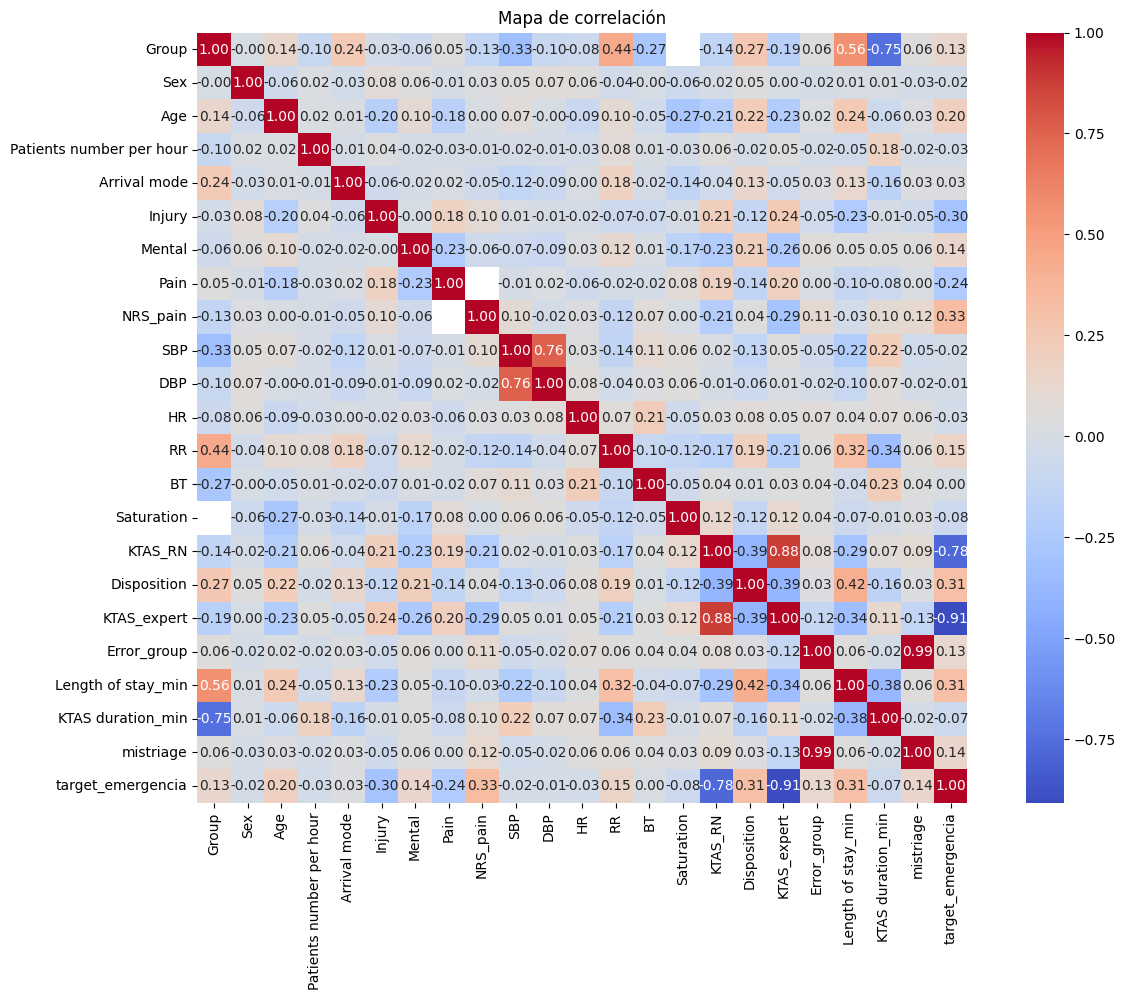

In [140]:
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Mapa de correlación")
plt.show()

### Correlaciones interesantes:
- KTAS_expert: -0.91 (esperado, ya que target_emergencia se deriva de ella).
- Disposición: 0.33 → quienes terminan admitidos o transferidos tienden a ser emergencias.
- Length_of_stay_min: 0.31 → lógica también; emergencias suelen quedarse más tiempo.
- NRS_pain, Mental, RR, BT, etc., tienen correlaciones menores a |0.2| con el target, pero:
    - No significa que no sean útiles: pueden tener efectos no lineales o actuar en conjunto.

In [141]:
df['target_emergencia'].value_counts()

target_emergencia
1    733
0    534
Name: count, dtype: int64

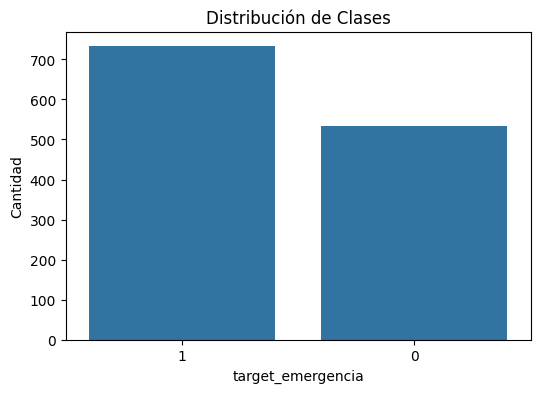

In [142]:
plt.figure(figsize=(6,4))
sns.countplot(x='target_emergencia', data=df, order=df['target_emergencia'].value_counts().index)
plt.title('Distribución de Clases')
plt.ylabel('Cantidad')
plt.xlabel('target_emergencia')
plt.show()

In [143]:
df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP',
       'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED',
       'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min',
       'KTAS duration_min', 'mistriage', 'target_emergencia'],
      dtype='object')

In [144]:
columnas_a_eliminar = [
    'KTAS_expert',
    'KTAS_RN',
    'Error_group',
    'mistriage',
    'Diagnosis in ED',
    'Chief_complain'
]

- KTAS_expert → Es la variable base del target, no debe estar si target_emergencia es el objetivo.
- KTAS_RN → Dato posterior al triaje de enfermería, introduce fuga de información.
- Error_group → Solo relevante si el objetivo fuera mistriage.
- mistriage → Ya no se usa como objetivo.
- Diagnosis in ED → Diagnóstico post-evaluación médica; fuga de datos.
- Chief_complain → Texto libre, no preprocesado aún; puede descartarse por ahora.

In [145]:
df.drop(columns=columnas_a_eliminar, inplace=True)

In [146]:
df.isnull().sum()

Group                         0
Sex                           0
Age                           0
Patients number per hour      0
Arrival mode                  0
Injury                        0
Mental                        0
Pain                          0
NRS_pain                    556
SBP                          25
DBP                          29
HR                           20
RR                           22
BT                           18
Saturation                  697
Disposition                   0
Length of stay_min            0
KTAS duration_min             0
target_emergencia             0
dtype: int64

In [147]:
missing_data = df.isnull().sum().to_frame('Faltantes')
missing_data['% Faltantes'] = (missing_data['Faltantes'] / df.shape[0] * 100).round(1)
missing_data['Tipo'] = df.dtypes
missing_data = missing_data[missing_data['Faltantes'] > 0]
missing_data = missing_data.sort_values(by='% Faltantes', ascending=False)
missing_data

,Faltantes,% Faltantes,Tipo
Saturation,697,55.0,float64
NRS_pain,556,43.9,float64
DBP,29,2.3,float64
SBP,25,2.0,float64
RR,22,1.7,float64
HR,20,1.6,float64
BT,18,1.4,float64


Mecanismo de pérdida:

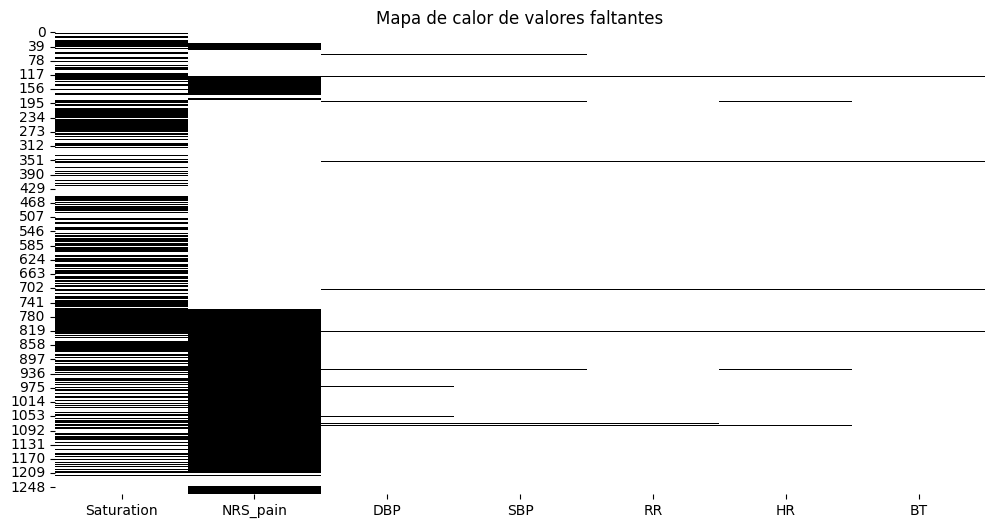

In [148]:
plt.figure(figsize=(12,6))
sns.heatmap(df[missing_data.index].isnull(), cbar=False, cmap='Greys')
plt.title("Mapa de calor de valores faltantes")
plt.show()

- Hay una gran coincidencia de valores nulos en Saturation y NRS_pain: muchos registros donde ambos faltan.
- Esto sugiere que el mecanismo de pérdida no es completamente aleatorio (≠ MCAR).
- Podría ser MAR (Missing At Random), por ejemplo:
    - Pacientes con saturación ausente también tienen NRS ausente porque son casos leves.

    - O bien, en situaciones de emergencia grave, la prioridad no fue registrar esos campos.

### Planteamiento de hipótesis:

Basado en:
- Conocimiento del contexto clínico.
- Lo que esperamos que influya en el registro o no de un dato.
- Variables que no tienen nulos y nos sirven como referencia o "punto de control".

#### Saturation

In [149]:
# Nueva variable binaria: ¿tiene Saturation faltante?
df['saturation_missing'] = df['Saturation'].isnull()

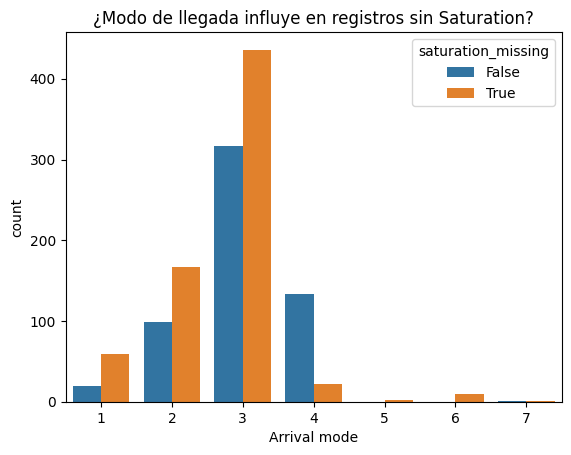

In [150]:
sns.countplot(x='Arrival mode', hue='saturation_missing', data=df)
plt.title("¿Modo de llegada influye en registros sin Saturation?")
plt.show()

- 1 = A pie,
- 2 = Ambulancia pública,
- 3 = Vehículo privado,
- 4 = Ambulancia privada,
- 5, 6, 7 = Otro

Análisis:

- En el modo de llegada 3 (vehículo privado) hay muchísimos más nulos que no nulos.
- En modo 1 (caminando) y 2 (ambulancia pública) también se nota una proporción mayor de nulos.

Insight:

- Esto respalda la hipótesis: los pacientes que llegan por su cuenta reciben menos monitoreo completo ➝ MAR (Missing At Random).

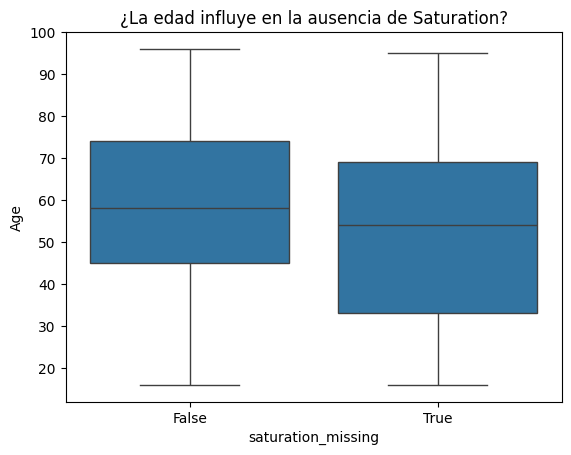

In [151]:
sns.boxplot(x='saturation_missing', y='Age', data=df)
plt.title("¿La edad influye en la ausencia de Saturation?")
plt.show()

Hay una pequeña diferencia, pero no suficiente para indicar que la edad sea un gran predictor del faltante. Es más probable MCAR o MAR débil, pero no MNAR.

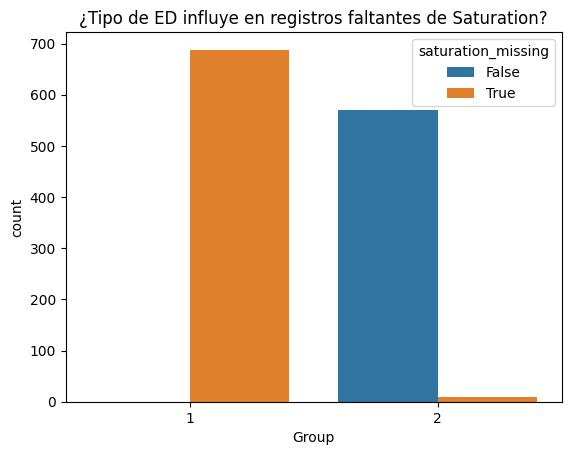

In [152]:
sns.countplot(x='Group', hue='saturation_missing', data=df)
plt.title("¿Tipo de ED influye en registros faltantes de Saturation?")
plt.show()

Tipo de DE: 
- 1 = DE local de 3.º grado
- 2 = DE regional de 4.º grado

Análisis:
- En el grupo 1 (local) hay casi todos los registros faltantes
Insight:
- Altísima dependencia ➝ MAR claro. En EDs locales probablemente no tienen oxímetro o no priorizan ese registro.

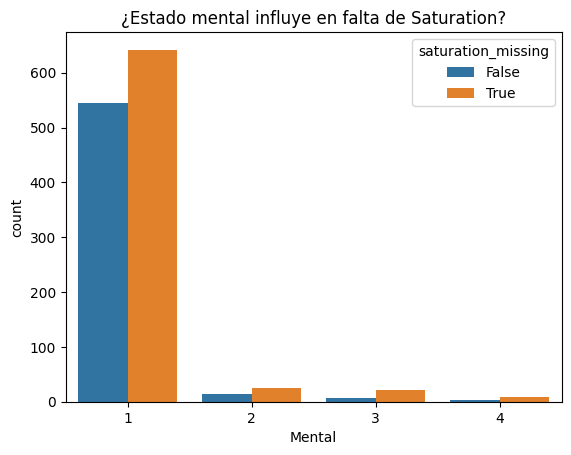

In [153]:
sns.countplot(x='Mental', hue='saturation_missing', data=df)
plt.title("¿Estado mental influye en falta de Saturation?")
plt.show()

Mental: 
- 1 = Alerta
- 2 = Respuesta verbal
- 3 = Respuesta al dolor
- 4 = Sin respuesta

Contrario a lo esperado, no hay evidencia de MNAR aquí. Parece que el registro se omite incluso en pacientes conscientes, lo que indica un MAR general, no condicionado por gravedad.

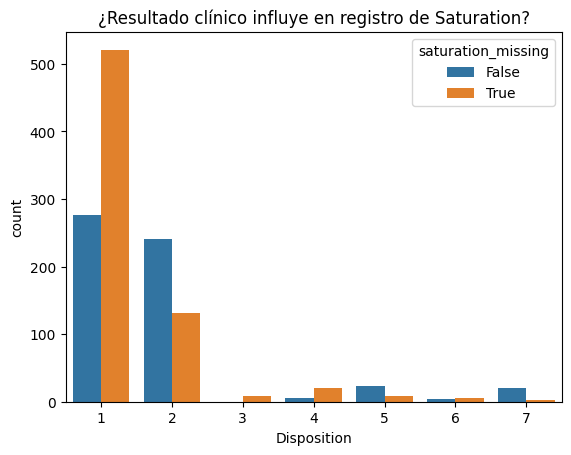

In [154]:
sns.countplot(x='Disposition', hue='saturation_missing', data=df)
plt.title("¿Resultado clínico influye en registro de Saturation?")
plt.show()

- 1 = Alta médica (discharge)
- 2 = Admitido a hospitalización
- 3 = UCI
- 4 = Alta (alternativa o administrativa)
- 5 = Transferido
- 6 = Fallecido
- 7 = Cirugía


Análisis:
- Mayoría de faltantes están en pacientes que fueron dados de alta (1)
- Los pacientes con resultados graves (UCI, muerte, cirugía) tienden a tener el registro más completo.

Insight:
- Hay un patrón claro: los casos leves tienen más nulos, lo cual es coherente con un MAR relacionado a severidad percibida.

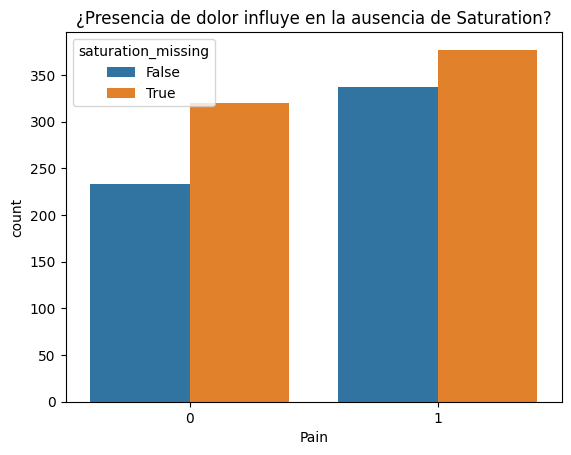

In [155]:
sns.countplot(x='Pain', hue='saturation_missing', data=df)
plt.title("¿Presencia de dolor influye en la ausencia de Saturation?")
plt.show()

Otro caso de MAR leve: la presencia de dolor parece influir en si se registran más signos vitales como la saturación.

#### CONCLUSIÓN FINAL SOBRE Saturation

Predominantemente MAR (Missing At Random), con posibles razones contextuales:

- Tipo de ED (locales no lo registran).
- Percepción de baja gravedad (alta médica, sin dolor, caminando).

In [156]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [157]:
df_reg = df.dropna(subset=['Saturation'])

In [158]:
features = ['Group', 'Sex', 'Age', 'Arrival mode', 'Injury', 'Mental', 'Pain', 'Disposition']
X = df_reg[features]
y = df_reg['Saturation']

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [160]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [161]:
y_pred = model.predict(X_test)

In [162]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [163]:
print(f"📉 MAE (Error absoluto medio): {mae:.2f}")
print(f"📉 RMSE (Raíz del error cuadrático medio): {rmse:.2f}")
print(f"📈 R² (Coef. de determinación): {r2:.2f}")

📉 MAE (Error absoluto medio): 2.26
📉 RMSE (Raíz del error cuadrático medio): 7.09
📈 R² (Coef. de determinación): 0.03


Aunque el error absoluto es bajo, la capacidad explicativa del modelo es muy limitada. El valor de `Saturation` **no puede predecirse de forma confiable** con las variables observadas. Imputar con este modelo puede introducir sesgos.

Por lo tanto, mejor crear una variable auxiliar:

In [164]:
df['saturation_measured'] = df['Saturation'].notnull().astype(int)

#### NRS_pain


In [165]:
df['nrspain_missing'] = df['NRS_pain'].isnull().astype(int)

In [166]:
features = ['Group', 'Sex', 'Age', 'Arrival mode', 'Injury', 'Mental', 'Pain', 'Disposition']
df_clf = df[features + ['nrspain_missing']].dropna()

In [167]:
X = df_clf[features]
y = df_clf['nrspain_missing']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [169]:
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train, y_train)
y_pred = clf_model.predict(X_test)

In [170]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       181
           1       1.00      0.99      1.00       136

    accuracy                           1.00       317
   macro avg       1.00      1.00      1.00       317
weighted avg       1.00      1.00      1.00       317



El mecanismo de pérdida es MAR (Missing At Random)

Verificar relación con campo 'Pain'

In [171]:
pd.crosstab(df['Pain'], df['NRS_pain'].isnull(), 
            rownames=['Pain'], colnames=['NRS_pain is null'])

NRS_pain is null,False,True
Pain,,
0,0,553
1,711,3


- Imputar NRS_pain = 0 cuando Pain == 0 y esté nulo.
- Imputar la mediana de los casos Pain == 1 para esos poquitos registros atípicos donde NRS_pain está nulo aunque Pain = 1.

In [172]:
df.loc[(df['Pain'] == 0) & (df['NRS_pain'].isnull()), 'NRS_pain'] = 0

In [173]:
mediana_pain1 = df.loc[(df['Pain'] == 1), 'NRS_pain'].median()
df.loc[(df['Pain'] == 1) & (df['NRS_pain'].isnull()), 'NRS_pain'] = mediana_pain1

In [174]:
df.isnull().sum()

Group                         0
Sex                           0
Age                           0
Patients number per hour      0
Arrival mode                  0
Injury                        0
Mental                        0
Pain                          0
NRS_pain                      0
SBP                          25
DBP                          29
HR                           20
RR                           22
BT                           18
Saturation                  697
Disposition                   0
Length of stay_min            0
KTAS duration_min             0
target_emergencia             0
saturation_missing            0
saturation_measured           0
nrspain_missing               0
dtype: int64

In [175]:
missing_data = df.isnull().sum().to_frame('Faltantes')
missing_data['% Faltantes'] = (missing_data['Faltantes'] / df.shape[0] * 100).round(1)
missing_data['Tipo'] = df.dtypes
missing_data = missing_data[missing_data['Faltantes'] > 0]
missing_data = missing_data.sort_values(by='% Faltantes', ascending=False)
missing_data

,Faltantes,% Faltantes,Tipo
Saturation,697,55.0,float64
DBP,29,2.3,float64
SBP,25,2.0,float64
RR,22,1.7,float64
HR,20,1.6,float64
BT,18,1.4,float64


Imputación y tratamiento de outliers

In [ ]:
def plot_boxplot_and_hist(data, variable):
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True,
        gridspec_kw={"height_ratios": (0.50, 1)},
        figsize=(8, 6)
    )
    sns.boxplot(x=data[variable], ax=ax_box, color='tomato')
    sns.histplot(data[variable], ax=ax_hist, bins=30, kde=True)
    plt.title('Distribución de ' + variable)
    plt.show()

#### 1. DBP (Presión diastólica)

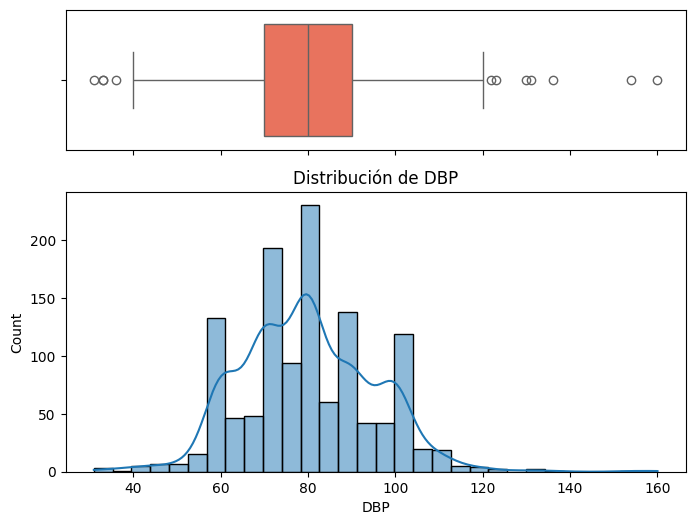

In [177]:
plot_boxplot_and_hist(df, 'DBP')

- Distribución: simétrica leve, con varios outliers.
- Imputación recomendada: **mediana**.
- Outliers: presentes, pero no extremos → **conservarlos** por ahora (informativos clínicamente).

In [178]:
df['DBP'] = df['DBP'].fillna(df['DBP'].median())

#### 2. SBP (Presión sistólica)

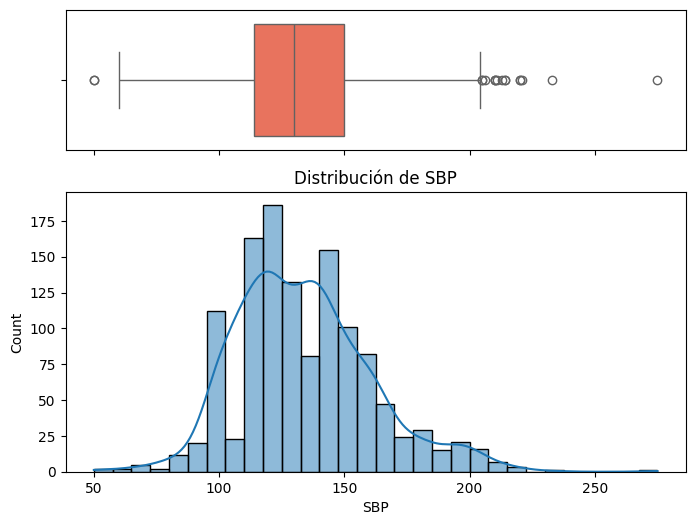

In [179]:
plot_boxplot_and_hist(df, 'SBP')

- Distribución: sesgada a la derecha (asimétrica).
- Imputación recomendada: **mediana**.
- Outliers: varios >200 mmHg → se recomienda **capping** (Winsorization).

In [180]:
df['SBP'] = df['SBP'].fillna(df['SBP'].median())

In [181]:
from scipy.stats import mstats

In [182]:
df['SBP'] = mstats.winsorize(df['SBP'], limits=[0.01, 0.01])

#### 3. RR (Frecuencia respiratoria)

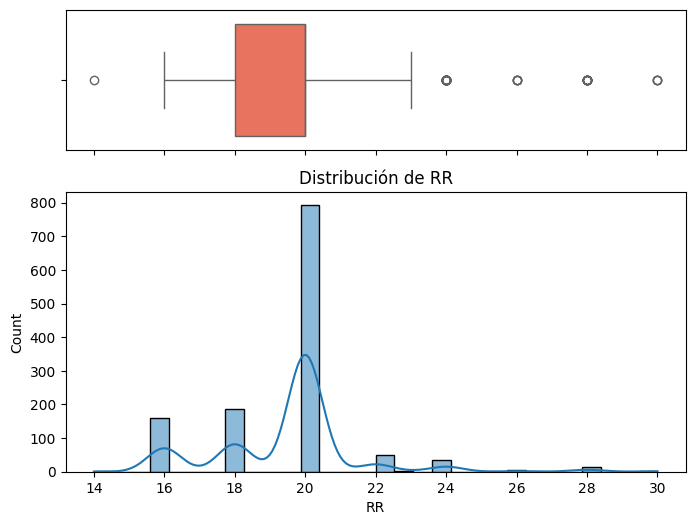

In [183]:
plot_boxplot_and_hist(df, 'RR')

- Distribución: multimodal, sesgada por registros comunes (e.g., picos en 20).
- Imputación recomendada: **moda**.
- Outliers: mínimos → **dejarlos** (están dentro de rango clínico esperado).

In [184]:
df['RR']  = df['RR'].fillna(df['RR'].mode()[0])

#### 4. HR (Frecuencia cardíaca)

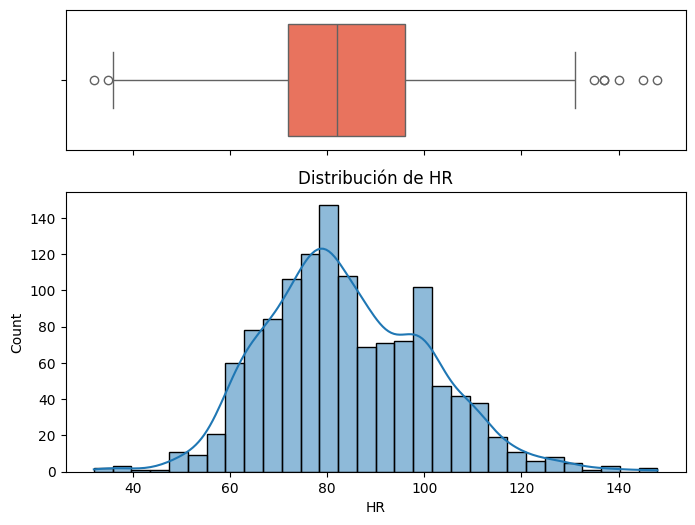

In [185]:
plot_boxplot_and_hist(df, 'HR')

- Distribución: relativamente normal, con ligera cola derecha.
- Imputación recomendada: **media** o **mediana** (ambas son razonables).
- Outliers: no críticos → **no se eliminan**.

In [186]:
df['HR']  = df['HR'].fillna(df['HR'].median())

#### 5. BT (Temperatura corporal)

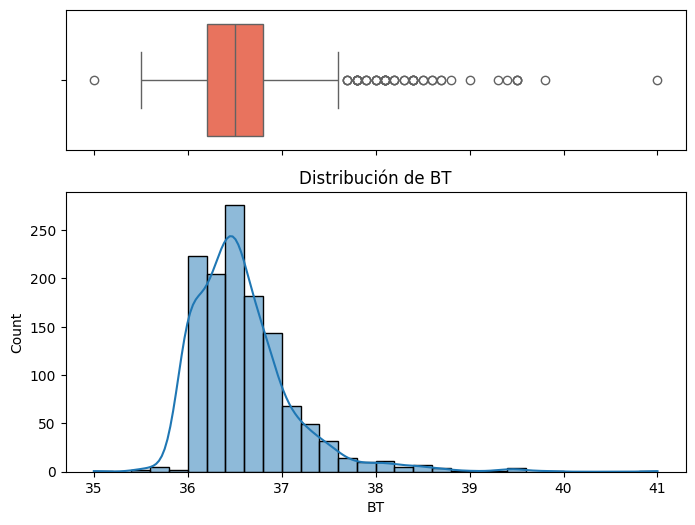

In [187]:
plot_boxplot_and_hist(df, 'BT')

- Distribución: sesgada derecha, muchos valores entre 36–37°C.
- Imputación recomendada: **mediana**.
- Outliers > 39–40°C → raros pero clínicamente posibles → **capping moderado si se desea suavizar**.

In [188]:
df['BT']  = df['BT'].fillna(df['BT'].median())

In [189]:
df['BT'] = mstats.winsorize(df['BT'], limits=[0, 0.01])

1. **Variables con nulos eliminadas o imputadas:**
   - `NRS_pain`: imputado según regla lógica basada en `Pain`.
   - `Saturation`: se conservó con su variable binaria `saturation_measured`.
   - `DBP`, `SBP`, `HR`, `RR`, `BT`: imputadas según distribución y outliers.

2. **Técnicas de imputación aplicadas:**
   - `DBP`, `SBP`, `HR`, `BT`: **mediana** por sesgo y outliers.
   - `RR`: **moda**, dada la multimodalidad del dato.
   - `BT` y `SBP`: **winsorización** al 1% superior para suavizar valores extremos clínicamente válidos.

In [190]:
df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT',
       'Saturation', 'Disposition', 'Length of stay_min', 'KTAS duration_min',
       'target_emergencia', 'saturation_missing', 'saturation_measured',
       'nrspain_missing'],
      dtype='object')

#### Columnas irrelevantes:

- 'saturation_missing',   # solo indica que faltaba
- 'nrspain_missing',      # lo mismo
- 'Length of stay_min',   # dato post atención (fuga de información)
- 'KTAS duration_min',    # también posterior al triaje
- 'Disposition'           # resultado clínico, no debe usarse si no está disponible al inicio

In [191]:
columnas_a_eliminar = [
    'saturation_missing',
    'nrspain_missing',
    'Saturation',
    'Length of stay_min', 
    'KTAS duration_min',
    'Disposition'
]

In [192]:
df.drop(columns=columnas_a_eliminar, inplace=True)

In [193]:
df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT',
       'target_emergencia', 'saturation_measured'],
      dtype='object')

In [195]:
df.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,target_emergencia,saturation_measured
0,2,2,71,3,3,2,1,1,2.0,160.0,100.0,84.0,18.0,36.6,0,1
1,1,1,56,12,3,2,1,1,2.0,137.0,75.0,60.0,20.0,36.5,0,0
2,2,1,68,8,2,2,1,1,2.0,130.0,80.0,102.0,20.0,36.6,0,1
3,1,2,71,8,1,1,1,1,3.0,139.0,94.0,88.0,20.0,36.5,0,0
4,1,2,58,4,3,1,1,1,3.0,91.0,67.0,93.0,18.0,36.5,0,0


In [194]:
df.to_csv("./data/dataset_clean.csv", index=False)